In [1]:
import pandas as pd
import numpy as np

mw_states = ['AK', 'FL', 'MO', 'MT', 'NJ', 'OH', 'SD', 'AZ', 'CO', 
             'ME', 'WA', 'CA', 'CT', 'HI', 'MA', 'MI', 'NY', 'VT',
             'RI', 'AR', 'MN', 'DE', 'MI', 'IL', 'DC', 'WV', 'NM']

mw = lambda x: np.where(x.STATE.isin(mw_states), 
                        'State Increased MW', 
                        'No State MW Increase')

wage_group_cut_points = [0, 7.25, 10, 12.0, 15, 20, 25, 
                         30, 35, 40, 45, 50, 2000]

wgrp = lambda x: pd.cut(x.HRWAGE, bins=wage_group_cut_points)

agghrs = lambda x: np.where(x.HRSACT1 > 0, 
                            x.HRSACT1 * (x.PWORWGT / 12), 
                            0)

cols = ['MONTH', 'STATE', 'HRWAGE', 'PWORWGT', 'HRSACT1']

def read_wage_data(year, columns=cols):
    '''
    Retrieve valid observations from selected columns from 
    bd CPS file for specified year
    '''
    return (pd.read_feather(f'data/clean/cps{year}.ft', columns=cols)
              .query('PWORWGT > 0 and HRWAGE > 0')
              .assign(STATE_GROUP = mw,
                      AGGHRS = agghrs,
                      WAGE_GROUP = wgrp))

data_2016 = read_wage_data(2016)

data_latest = (read_wage_data(2018).query('MONTH == 12')
               .append(read_wage_data(2019)))

def hours_by_group(df, columns=['STATE_GROUP', 'WAGE_GROUP']):
    '''
    Calculate aggregate hours for wage and state groups
    '''
    return df.groupby(columns).AGGHRS.sum().unstack().T.iloc[::-1]

group_hours_2016 = hours_by_group(data_2016)
total_hours_2016 = data_2016.AGGHRS.sum()
group_hours_latest = hours_by_group(data_latest)
total_hours_latest = data_latest.AGGHRS.sum()
result_2016 = (group_hours_2016 / total_hours_2016) * 100
result_latest = (group_hours_latest / total_hours_latest) * 100

total_hours_growth = ((total_hours_latest / total_hours_2016) - 1) * 100
group_hours_growth = ((group_hours_latest / group_hours_2016) - 1) * 100

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.rc('font', family='Lato', weight=3)

def wage_group_plot(df, date_text, img_file_name):
    '''
    Plot the wage group data
    '''
    title = f'Hours worked by wage group, as share of total US hours, \n 12-months ending {date_text}'

    df.plot(kind='barh',
            figsize=(7, 10), 
            width=0.75, 
            xlim=(0, 11), 
            color=['skyblue', 'green'])

    wage_group_labels = [[i, f'${val.left + 0.01} to {val.right:.2f}'] 
                         for i, val in enumerate(df.index)]
    
    wage_group_labels[0][1] = '$50.00+'

    for y_loc, name in wage_group_labels:
        plt.text(-0.2, y_loc, name, fontsize=12, 
                 ha='right', va='center')

    no_increase_state_labels = [[i, val - 0.1, f'{val:.1f}'] 
                                for i, val in enumerate(df.iloc[:,0])]

    for y_loc, x_loc, name in no_increase_state_labels:
        plt.text(x_loc, y_loc - 0.2, name, fontsize=10, 
                 ha='right', va='center', weight='bold')

    mw_increase_state_labels = [[i, val - 0.1, f'{val:.1f}'] 
                                for i, val in enumerate(df.iloc[:,1])]

    for y_loc, x_loc, name in mw_increase_state_labels:
        plt.text(x_loc, y_loc + 0.18, name, fontsize=10, 
                 ha='right', va='center', color='white', weight='bold')

    ax = plt.gca()

    plt.text(-3, 12.0, title, fontsize=15, weight='bold')


    plt.text(-3, -0.8, "Source: Author's calculations from basic CPS microdata files",
             fontsize=12)

    handles, labels = ax.get_legend_handles_labels()

    legend_labels = ['State with minimum wage increase', 
                     'No state minimum wage increase']

    ax.legend(handles[::-1], legend_labels, frameon=False, 
              loc='upper right', bbox_to_anchor=(0.88, 1.02), fontsize=12)    

    plt.axis('off')
    plt.savefig(img_file_name, bbox_inches='tight')
    plt.show();

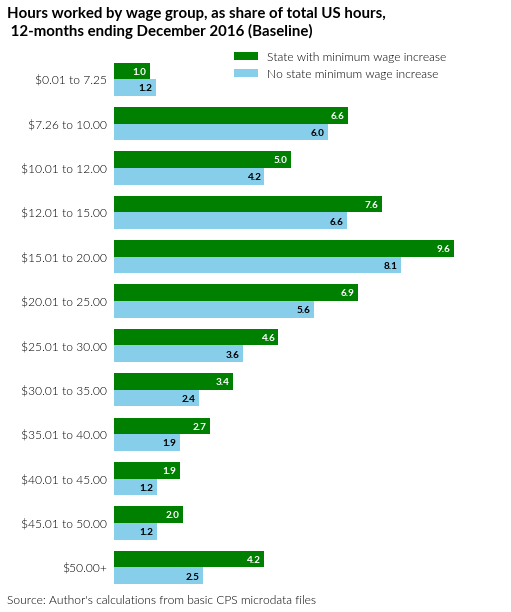

In [3]:
wage_group_plot(result_2016, 'December 2016 (Baseline)', 'result2016.png')

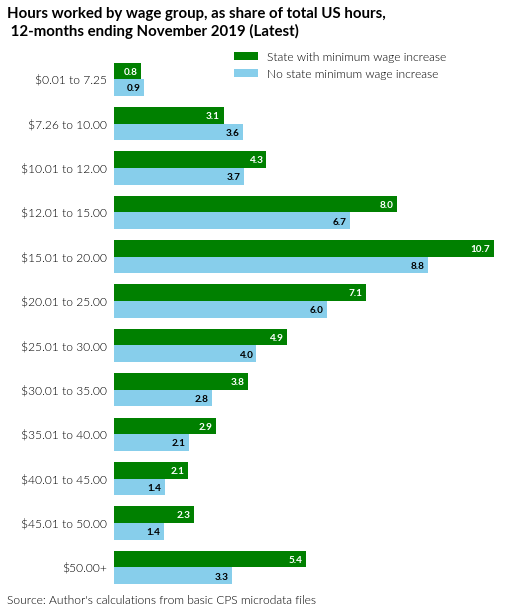

In [4]:
wage_group_plot(result_latest, 'November 2019 (Latest)', 'resultlatest.png')